# Modelo de tarifación Airbnb en New York

Versión previa Nov 3, 2020
Modificado May 3, 2021

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models, layers, optimizers, regularizers
from numpy.random import seed
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
import time
import math
import numpy as np
seed(123)
print(tf.__version__)

2.4.0


In [2]:
pd.options.display.max_columns = None
pd.options.display.max_rows= None

## Dataset de entrada

In [3]:
dataset=pd.read_csv('Listings_clean.csv')

In [4]:
dataset=dataset.dropna()
print('El dataset de entrada contiene', len(dataset.columns), 'columnas', 'y', len(dataset), 'filas')

El dataset de entrada contiene 39 columnas y 35637 filas


In [5]:
dataset.dtypes

Unnamed: 0                          int64
id                                  int64
host_is_superhost                 float64
host_listings_count               float64
host_has_profile_pic              float64
host_identity_verified            float64
latitude                          float64
longitude                         float64
accommodates                        int64
bedrooms                          float64
beds                              float64
price                             float64
minimum_nights                      int64
maximum_nights                      int64
has_availability                    int64
availability_365                    int64
number_of_reviews                   int64
instant_bookable                    int64
calculated_host_listings_count      int64
t_bathrooms                       float64
am_wifi                             int64
am_air conditioning                 int64
am_kitchen                          int64
am_parking                        

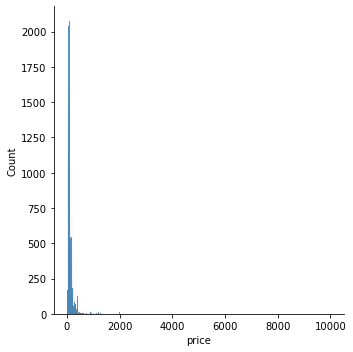

In [6]:
sns.displot(dataset['price'])
plt.show()

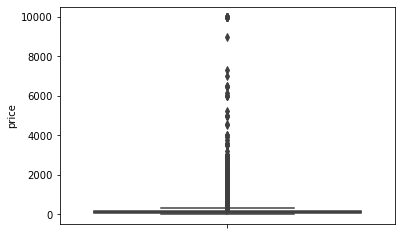

In [7]:
sns.boxplot(y=dataset['price'])
plt.show()

In [8]:
dataset['price'].describe()

count    35637.000000
mean       149.271151
std        294.259304
min          0.000000
25%         62.000000
50%        100.000000
75%        160.000000
max      10000.000000
Name: price, dtype: float64

In [9]:
dataset=dataset[(dataset['price']>0)&(dataset['price']<200)]

In [10]:
dataset.head(3)

,Unnamed: 0,id,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,has_availability,availability_365,number_of_reviews,instant_bookable,calculated_host_listings_count,t_bathrooms,am_wifi,am_air conditioning,am_kitchen,am_parking,am_patio,am_barbecue,am_outdoor,am_games,am_soap,am_shampoo,apartment,house,other,room,entire home/apt,private room,shared room,private,shared
0,0,2595,0.0,6.0,1.0,1.0,40.75356,-73.98559,2,1.318137,1.0,150.0,30,1125,1,365,48,0,3,1.0,1,1,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0
1,1,3831,0.0,1.0,1.0,1.0,40.68494,-73.95765,3,1.000000,3.0,76.0,1,730,1,198,396,0,1,1.0,1,1,1,1,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0
2,2,5121,0.0,1.0,1.0,1.0,40.68535,-73.95512,2,1.000000,1.0,60.0,30,730,1,365,50,0,1,0.5,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0


In [11]:
dataset=dataset.drop(['Unnamed: 0', 'id'], axis=1)

In [12]:
dataset['price']=np.log(dataset['price'])

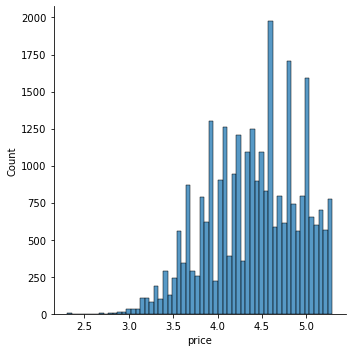

In [13]:
sns.displot(dataset['price'])
plt.show()

## Dividiendo los datos en entrenamiento y testing

In [14]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [15]:
train_dataset.head(6)

,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,has_availability,availability_365,number_of_reviews,instant_bookable,calculated_host_listings_count,t_bathrooms,am_wifi,am_air conditioning,am_kitchen,am_parking,am_patio,am_barbecue,am_outdoor,am_games,am_soap,am_shampoo,apartment,house,other,room,entire home/apt,private room,shared room,private,shared
19043,0.0,1.0,1.0,1.0,40.83808,-73.94486,1,1.0,1.0,3.610918,13,1125,1,0,2,0,1,1.0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1
16510,0.0,17.0,1.0,1.0,40.69609,-73.93916,2,1.0,2.0,3.610918,30,1125,1,189,4,0,14,6.5,1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1
21755,1.0,2.0,1.0,1.0,40.81325,-73.94841,2,1.0,0.0,4.700480,5,28,1,353,48,1,2,1.0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0
21359,0.0,1.0,1.0,1.0,40.77836,-73.95373,3,1.0,1.0,5.010635,30,1125,1,0,4,1,1,1.0,1,1,1,0,1,0,0,0,0,1,1,0,0,0,1,0,0,1,0
23309,0.0,8.0,1.0,0.0,40.76451,-73.98360,2,1.0,1.0,5.187386,1,1125,1,1,13,1,8,1.0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1
35875,0.0,0.0,1.0,1.0,40.75286,-73.87619,2,1.0,1.0,3.258097,30,1125,1,41,0,0,28,1.0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1


## Descriptivo

In [16]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
host_is_superhost,23594.0,0.181487,0.385429,0.000000,0.000000,0.000000,0.000000,1.000000e+00
host_listings_count,23594.0,12.913114,83.440399,0.000000,1.000000,1.000000,3.000000,2.232000e+03
host_has_profile_pic,23594.0,0.997118,0.053609,0.000000,1.000000,1.000000,1.000000,1.000000e+00
host_identity_verified,23594.0,0.801941,0.398545,0.000000,1.000000,1.000000,1.000000,1.000000e+00
latitude,23594.0,40.728744,0.056842,40.521980,40.688590,40.722580,40.763288,4.091714e+01
longitude,23594.0,-73.946371,0.049349,-74.191130,-73.979730,-73.951695,-73.927415,-7.371087e+01
accommodates,23594.0,2.451004,1.388930,1.000000,2.000000,2.000000,3.000000,1.600000e+01
bedrooms,23594.0,1.202782,0.480306,1.000000,1.000000,1.000000,1.000000,1.100000e+01
beds,23594.0,1.376388,0.867802,0.000000,1.000000,1.000000,2.000000,2.100000e+01
price,23594.0,4.415384,0.512388,2.302585,4.025352,4.454347,4.828314,5.293305e+00


In [17]:
test_stats = test_dataset.describe()
test_stats = test_stats.transpose()
test_stats

,count,mean,std,min,25%,50%,75%,max
host_is_superhost,5899.0,0.178844,3.832540e-01,0.000000,0.000000,0.000000,0.000000,1.000000e+00
host_listings_count,5899.0,10.868622,6.338405e+01,0.000000,1.000000,1.000000,3.000000,1.471000e+03
host_has_profile_pic,5899.0,0.997966,4.506051e-02,0.000000,1.000000,1.000000,1.000000,1.000000e+00
host_identity_verified,5899.0,0.799458,4.004402e-01,0.000000,1.000000,1.000000,1.000000,1.000000e+00
latitude,5899.0,40.728075,5.670745e-02,40.538940,40.688505,40.722810,40.763085,4.091685e+01
longitude,5899.0,-73.946429,5.002755e-02,-74.210880,-73.979775,-73.952100,-73.928310,-7.371299e+01
accommodates,5899.0,2.444482,1.381008e+00,1.000000,2.000000,2.000000,3.000000,1.600000e+01
bedrooms,5899.0,1.211141,4.815958e-01,1.000000,1.000000,1.000000,1.000000,7.000000e+00
beds,5899.0,1.381061,8.661626e-01,0.000000,1.000000,1.000000,2.000000,1.200000e+01
price,5899.0,4.411143,5.075222e-01,2.302585,4.025352,4.442651,4.828314,5.293305e+00


## Normalizando

In [18]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

# Separando caracteristicas y etiquetas

In [19]:
train_labels = normed_train_data.pop('price')
test_labels = normed_test_data.pop('price')

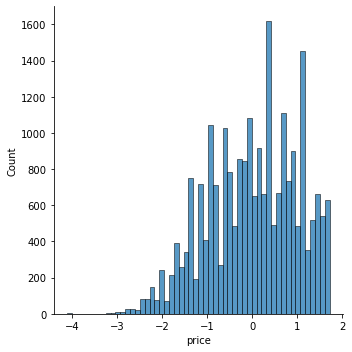

In [20]:
sns.displot(train_labels)
plt.show()

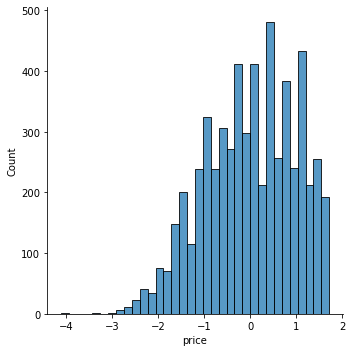

In [21]:
sns.displot(test_labels)

# El modelo

### Construye el modelo

In [22]:
# ,kernel_regularizer=regularizers.l2(0.05)
# La mejor que llevo es 256, 128, 16, dropout 0.1 y sin regularizador
def build_model():  
  model = keras.Sequential([
    layers.Dense(128, activation='relu',input_shape=[len(normed_train_data.keys())]),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    #layers.Dense(64, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
  ])

  optimizer=Adam(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [23]:
model = build_model()

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               4736      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 25,409
Trainable params: 25,409
Non-trainable params: 0
____________________________________________________

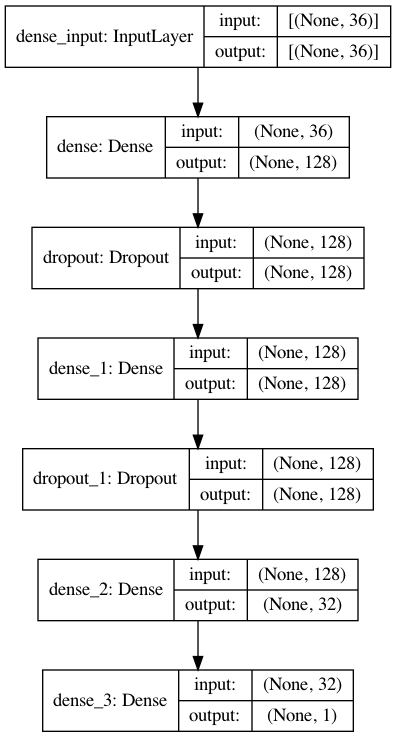

In [25]:
plot_model(model, to_file='regresion_model_keras.png', show_shapes=True)

In [26]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.04255131],
       [-0.44853374],
       [-0.01701942],
       [ 0.22091496],
       [-0.1995978 ],
       [-0.01322224],
       [ 0.00869205],
       [ 2.0754335 ],
       [-0.04474616],
       [ 0.31397143]], dtype=float32)

### Entrenamiento del modelo

In [27]:
# Display training progress by printing a single dot for each completed epoch
time_start = time.time()

class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 250

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

time_end = time.time()
print(f"\nTiempo de ejecución: {round((time_end - time_start)/60,1)} minutos")


....................................................................................................
....................................................................................................
..................................................
Tiempo de ejecución: 4.6 minutos


In [28]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
245,0.271910,0.406789,0.271910,0.399516,0.490397,0.399516,245
246,0.275545,0.409187,0.275545,0.401503,0.491969,0.401503,246
247,0.272712,0.407907,0.272712,0.398064,0.487279,0.398064,247
248,0.275112,0.408585,0.275112,0.400097,0.490307,0.400097,248
249,0.272263,0.406537,0.272263,0.398957,0.489002,0.398957,249


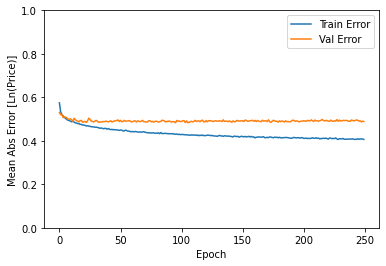

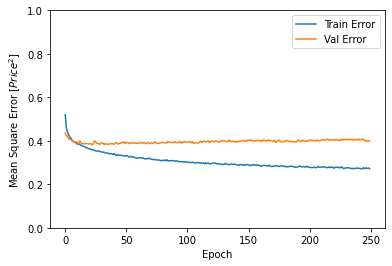

In [29]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [Ln(Price)]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0.0,1])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$Price^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0.0,1])
  plt.legend()
  plt.show()


plot_history(history)


.........................

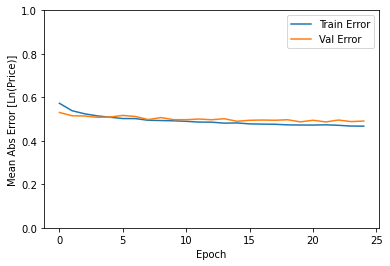

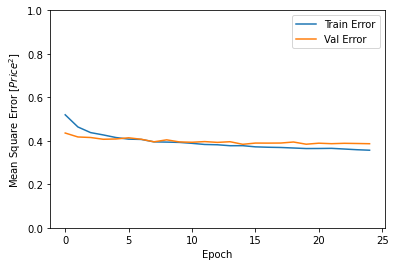

In [30]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [31]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f}".format(mae))

185/185 - 0s - loss: 4.5013 - mae: 0.5133 - mse: 4.5013
Testing set Mean Abs Error:  0.51


## Predicciones

5899


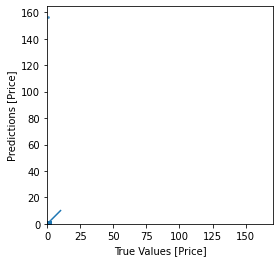

In [32]:
test_predictions = model.predict(normed_test_data).flatten()
print(len(test_predictions))
plt.scatter(test_labels, test_predictions,alpha=0.7,s=3)
plt.xlabel('True Values [Price]')
plt.ylabel('Predictions [Price]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-10, 10], [-10, 10]) #El modelo subestima para precios mayores a 200 dolares

5899


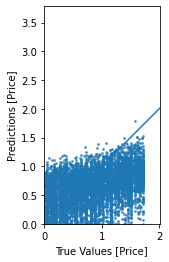

In [33]:
train_predictions = model.predict(normed_train_data).flatten()
print(len(test_predictions))
plt.scatter(train_labels, train_predictions,alpha=0.7,s=3)
plt.xlabel('True Values [Price]')
plt.ylabel('Predictions [Price]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-10, 10], [-10, 10])

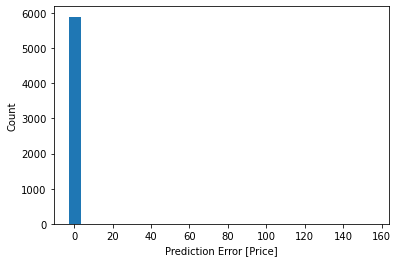

In [34]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Price]")
_ = plt.ylabel("Count")

In [35]:
y_test_pred = model.predict(normed_test_data)
y_train_pred = model.predict(normed_train_data)
print("Training MSE:", round(mean_squared_error(train_labels, y_train_pred),4))
print("Validation MSE:", round(mean_squared_error(test_labels, y_test_pred),4))
print("\nTraining r2:", round(r2_score(train_labels, y_train_pred),4))
print("Validation r2:", round(r2_score(test_labels, y_test_pred),4))

Training MSE: 0.3358
Validation MSE: 4.5013

Training r2: 0.6642
Validation r2: -3.5888


In [36]:
math.exp(0.0068)

1.0068231724945438